In [1]:
#imports
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from scipy.interpolate import lagrange
from numpy.polynomial.polynomial import Polynomial

In [2]:
def loadData(filename):
    with open(filename) as f:
        lines = f.readlines()
        rows = []
        for i in lines:
            data = i[:-1].split()
            rows.append([float(data[0]), float(data[1]), int(data[2])])
        return rows

In [3]:
class InternalNode:
    def __init__(self, feature, thres, left, right):
        self.leaf = False
        self.feature = feature
        self.thres = thres
        self.left = left
        self.right = right
    def __str__(self):
        return "InternalNode split on feature " + str(self.feature) +  " with thres " + str(self.thres)

In [4]:
class LeafNode:
    def __init__(self, data):
        self.leaf = True
        self.label = None
        self.left = None
        self.right = None
        if len(data) == 0:
            print("No input for leaf node")
            self.label = 1
        else:
            label0 = 0
            label1 = 0
            for i in data:
                if i[2] == 0:
                    label0 += 1
                else:
                    label1 += 1
            if label0 > label1:
                self.label = 0
            else:
                self.label = 1
    def __str__(self):
        return "LeafNode label" + str(self.label)

In [5]:
def gainRatio(part1, part2):
    p1_0 = 0
    p1_1 = 0
    p2_0 = 0
    p2_1 = 0
    for i in part1:
        if i[2] == 0:
            p1_0 += 1
        else:
            p1_1 += 1
    for i in part2:
        if i[2] == 0:
            p2_0 += 1
        else:
            p2_1 += 1
    total_0 = p1_0 + p2_0
    total_1 = p1_1 + p2_1
    total = total_0 + total_1
    H_Y = -((total_0 / total) * math.log2(total_0 / total) if total_0 > 0 else 0) - ((total_1 / total) * math.log2(total_1 / total) if total_1 > 0 else 0)
    H_Y_p1 = -((p1_0 / len(part1)) * math.log2(p1_0 / len(part1)) if p1_0 > 0 else 0) - ((p1_1 / len(part1)) * math.log2(p1_1 / len(part1)) if p1_1 > 0 else 0)
    H_Y_p2 = -((p2_0 / len(part2)) * math.log2(p2_0 / len(part2)) if p2_0 > 0 else 0) - ((p2_1 / len(part2)) * math.log2(p2_1 / len(part2)) if p2_1 > 0 else 0)
    infoGain = H_Y - ((len(part1) / total) * H_Y_p1 + (len(part2) / total) * H_Y_p2)
    H_S = -(((len(part1) / total) * math.log2(len(part1) / total) if len(part1) > 0 else 0) + ((len(part2) / total) * math.log2(len(part2) / total) if len(part2) > 0 else 0))
    gr = -math.inf
    if H_S > 0:
        gr = infoGain / H_S
    return infoGain, H_S, gr

In [6]:
def findBestSplit(data, display=False):
    highestGR = -math.inf
    feature = 0
    thres = 0
    partLeft = None
    partRight = None
    for featureIndex in [0,1]:
        featureSet = set([i[featureIndex] for i in data])
        for fea in featureSet:
            part1 = []
            part2 = []
            for i in data:
                if i[featureIndex] < fea:
                    part1.append(i)
                else:
                    part2.append(i)
            gr = gainRatio(part1, part2)
            if gr[1] > 0:
                if gr[2] > highestGR:
                    highestGR = gr[2]
                    feature = featureIndex
                    thres = fea
                    partLeft = part2
                    partRight = part1
            if display:
                print("Split on feature " + str(featureIndex) + " >= " + str(fea) + " . Gain ratio: " + (str(gr[2]) if gr[1] > 0 else ("undefined InfoGain: " + str(gr[0]))))
    return highestGR, feature, thres, partLeft, partRight

In [7]:
def decisionTree(data):
    if len(data) == 0:
        return LeafNode(data)
    bestSplit = findBestSplit(data)
    if bestSplit[0] <= 0:
        return LeafNode(data)
    left = decisionTree(bestSplit[3])
    right = decisionTree(bestSplit[4])
    return InternalNode(bestSplit[1], bestSplit[2], left, right)

In [8]:
def classify(instance, node):
    if node.leaf:
        return node.label
    if instance[node.feature] >= node.thres:
        return classify(instance, node.left)
    else:
        return classify(instance, node.right)

In [9]:
def printTree(node, level=0):
    print("       " * level + str(node))
    if node.left:
        printTree(node.left, level=level+1)
    if node.right:
        printTree(node.right, level=level+1)

In [10]:
def nodeCount(node):
    return 1 + (0 if node.left == None else nodeCount(node.left)) + (0 if node.right == None else nodeCount(node.right))

In [11]:
def plotData(data):
    plot = plt.scatter(x=data[:,0], y=data[:,1], c=data[:,2], cmap=plt.cm.get_cmap('autumn', 2))
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend(*plot.legend_elements())
    plt.show()


In [12]:
def plotDecisonBoundary(data, node):
    data = np.array(data)
    fea1, fea2 = np.meshgrid(np.arange(data[:,0].min(), data[:,0].max(), 0.01), np.arange(data[:,1].min(), data[:,1].max(), 0.01))
    pred = []
    for i in range(len(fea1)):
        for j in range(len(fea1[0])):
            pt = (fea1[i][j], fea2[i][j])
            pred.append(classify(pt, node))
    pred = np.array(pred).reshape(fea1.shape)
    plot = plt.contourf(fea1, fea2, pred, levels=[-1, 0, 1], cmap=plt.cm.get_cmap('autumn', 2))
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend([plt.Rectangle((1,1),2,1,facecolor = i.get_facecolor()[0]) for i in plot.collections], ["0", "1"])
    plt.show()

In [13]:
dbig = loadData('Dbig.txt')
d1 = loadData('D1.txt')
d2 = loadData('D2.txt')
druns = loadData('Druns.txt')
d3leaves = loadData("D3leaves.txt")
randPer = np.random.permutation(dbig).tolist()
d8192 = randPer[0:8192]
d32 = d8192[0:32]
d128 = d8192[0:128]
d512 = d8192[0:512]
d2048 = d8192[0:2048]
train = [d32, d128, d512, d2048, d8192]
test = randPer[8192:]

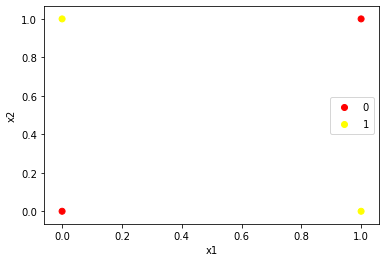

In [14]:
#q2
q2 = np.array([[0,0,0],[0,1,1],[1,0,1],[1,1,0]])
plotData(q2)

In [15]:
#q3
q3 = findBestSplit(druns, display=True)

Split on feature 0 >= 0.1 . Gain ratio: 0.10051807676021852
Split on feature 0 >= 0.0 . Gain ratio: undefined InfoGain: 0.0
Split on feature 1 >= 0.0 . Gain ratio: 0.055953759631263686
Split on feature 1 >= 1.0 . Gain ratio: 0.005780042205152451
Split on feature 1 >= 2.0 . Gain ratio: 0.0011443495172768668
Split on feature 1 >= 3.0 . Gain ratio: 0.016411136842102245
Split on feature 1 >= 4.0 . Gain ratio: 0.04974906418177866
Split on feature 1 >= 5.0 . Gain ratio: 0.1112402958633981
Split on feature 1 >= 6.0 . Gain ratio: 0.2360996061436081
Split on feature 1 >= 7.0 . Gain ratio: 0.055953759631263686
Split on feature 1 >= 8.0 . Gain ratio: 0.43015691613098095
Split on feature 1 >= -1.0 . Gain ratio: 0.10051807676021852
Split on feature 1 >= -2.0 . Gain ratio: undefined InfoGain: 0.0


In [16]:
#q4
root3 = decisionTree(d3leaves)
printTree(root3)

InternalNode split on feature 0 with thres 10.0
       LeafNode label1
       InternalNode split on feature 1 with thres 3.0
              LeafNode label1
              LeafNode label0


In [17]:
#q5
root1 = decisionTree(d1)
printTree(root1)

InternalNode split on feature 1 with thres 0.201829
       LeafNode label1
       LeafNode label0


In [18]:
root2 = decisionTree(d2)
printTree(root2)

InternalNode split on feature 0 with thres 0.533076
       InternalNode split on feature 1 with thres 0.228007
              InternalNode split on feature 1 with thres 0.424906
                     LeafNode label1
                     InternalNode split on feature 0 with thres 0.708127
                            LeafNode label1
                            InternalNode split on feature 1 with thres 0.32625
                                   InternalNode split on feature 0 with thres 0.595471
                                          InternalNode split on feature 0 with thres 0.646007
                                                 LeafNode label1
                                                 InternalNode split on feature 1 with thres 0.403494
                                                        LeafNode label1
                                                        LeafNode label0
                                          LeafNode label0
                                   LeafNo

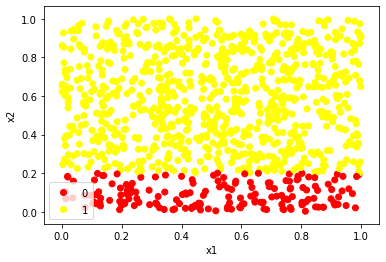

In [19]:
#q6
plotData(np.array(d1))

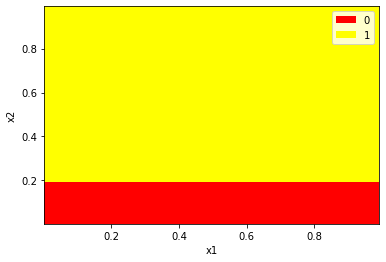

In [20]:
plotDecisonBoundary(d1, root1)

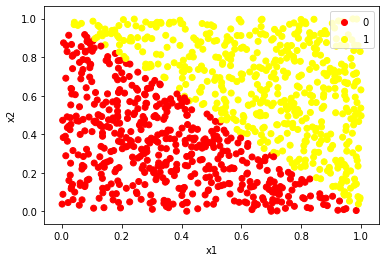

In [21]:
plotData(np.array(d2))

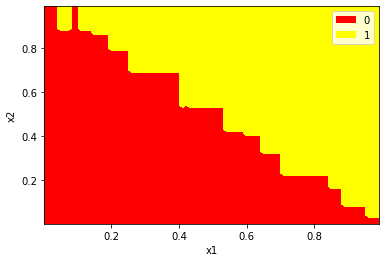

In [22]:
plotDecisonBoundary(d2, root2)

n = 32
number of nodes = 13
err = 0.07300884955752213


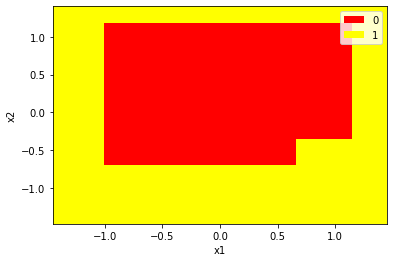

n = 128
number of nodes = 27
err = 0.053650442477876106


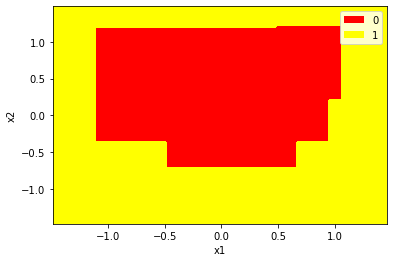

n = 512
number of nodes = 53
err = 0.05641592920353982


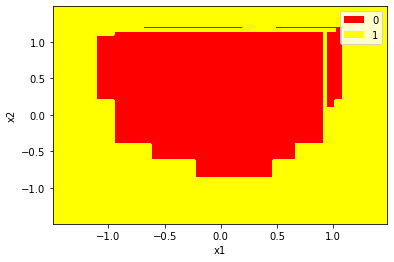

n = 2048
number of nodes = 109
err = 0.027101769911504425


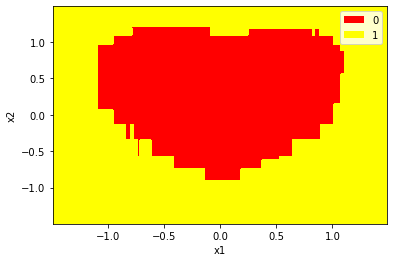

n = 8192
number of nodes = 263
err = 0.01327433628318584


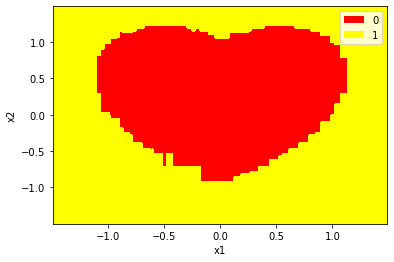

In [23]:
#q7
learningCurve = []
for i in train:
    root = decisionTree(i)
    counter = 0
    for j in test:
        if classify(j, root) != j[2]:
            counter += 1
    learningCurve.append([len(i), counter / len(test)])
    print("n = " + str(len(i)))
    print("number of nodes = " + str(nodeCount(root)))
    print("err = " + str(counter / len(test)))
    plotDecisonBoundary(i, root)

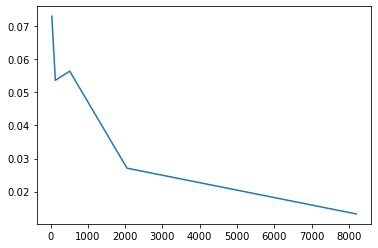

In [24]:
learningCurve = np.array(learningCurve)
plt.plot(learningCurve[:,0], learningCurve[:,1])
plt.show()

In [25]:
#Sklearn problem
learningCurve = []
for i in train:
    i = np.array(i)
    dt = tree.DecisionTreeClassifier().fit(i[:,[0,1]], i[:,2])
    counter = 0
    for j in test:
        if dt.predict([j[0:2]])[0] != j[2]:
            counter += 1
    learningCurve.append([len(i), counter / len(test)])
    print("n = " + str(len(i)))
    print("number of nodes = " + str(dt.tree_.node_count))
    print("err = " + str(counter / len(test)))

n = 32
number of nodes = 17
err = 0.22732300884955753
n = 128
number of nodes = 23
err = 0.07688053097345132
n = 512
number of nodes = 53
err = 0.042588495575221236
n = 2048
number of nodes = 117
err = 0.030420353982300884
n = 8192
number of nodes = 229
err = 0.012168141592920354


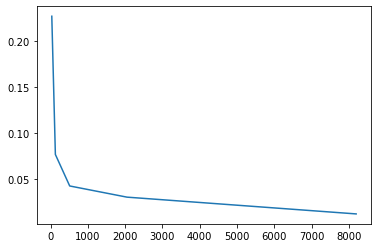

In [26]:
learningCurve = np.array(learningCurve)
plt.plot(learningCurve[:,0], learningCurve[:,1])
plt.show()

In [27]:
#Lagrange Interpolation problem
train_x = np.random.uniform(0,100,100)
train_y = np.sin(train_x)
test_x = np.random.uniform(0,100,100)
test_y = np.sin(test_x)
poly = lagrange(train_x, train_y)

In [28]:
print("train error = " + str(np.mean((poly(train_x) - train_y) ** 2)))
print("test error = " + str(np.mean((poly(test_x) - test_y) ** 2)))

train error = 4.0185848875700984e+151
test error = 4.5700116146280744e+151


In [29]:
std_base = 2
for i in range(1, 17):
    train_x_Noise = train_x + np.random.normal(0,std_base ** i, 100)
    train_y_Noise = np.sin(train_x_Noise)
    poly = lagrange(train_x_Noise, train_y_Noise)
    print("Noise standard error = " + str(std_base ** i))
    print("train error = " + str(np.mean((poly(train_x_Noise) - train_y_Noise) ** 2)))
    print("test error = " + str(np.mean((poly(test_x) - test_y) ** 2)))

Noise standard error = 2
train error = 1.2294676443943223e+153
test error = 4.7795911589425465e+152
Noise standard error = 4
train error = 1.6908060037542451e+156
test error = 2.5236256154889914e+154
Noise standard error = 8
train error = 3.715551883645195e+172
test error = 9.231199192799053e+165
Noise standard error = 16
train error = 7.4598330776845155e+158
test error = 2.0484035415536775e+145
Noise standard error = 32
train error = 5.049907757472203e+164
test error = 1.8874868359512578e+129
Noise standard error = 64
train error = 7.794460988799752e+115
test error = 3.186547651031182e+76
Noise standard error = 128
train error = 4.603650603314291e+123
test error = 3.649674225860869e+51
Noise standard error = 256
train error = 2.0611756672299416e+128
test error = 4.8621744776081846e+27
Noise standard error = 512
train error = 1.5122191504676087e+117
test error = 2.936079038276783e+23
Noise standard error = 1024
train error = 4.303885921443564e+123
test error = 267956055.74619907
Noise 

In [30]:
std_base = 20
for i in range(5, 13):
    train_x_Noise = train_x + np.random.normal(0,std_base * i, 100)
    train_y_Noise = np.sin(train_x_Noise)
    poly = lagrange(train_x_Noise, train_y_Noise)
    print("Noise standard error = " + str(std_base * i))
    print("train error = " + str(np.mean((poly(train_x_Noise) - train_y_Noise) ** 2)))
    print("test error = " + str(np.mean((poly(test_x) - test_y) ** 2)))

Noise standard error = 100
train error = 2.801985593434689e+125
test error = 5.952120232137653e+50
Noise standard error = 120
train error = 1.6917816297352355e+105
test error = 8.148148052046979e+32
Noise standard error = 140
train error = 6.239479550568416e+138
test error = 9.307663745242822e+34
Noise standard error = 160
train error = 2.840005030699731e+124
test error = 2.3377731025333686e+27
Noise standard error = 180
train error = 4.731005664235127e+116
test error = 1.1451804396531785e+25
Noise standard error = 200
train error = 9.484382888312022e+107
test error = 172276815716250.53
Noise standard error = 220
train error = 2.7223284050459283e+125
test error = 6.692880440972904e+20
Noise standard error = 240
train error = 5.379491776401314e+125
test error = 2620649882047.8555
